In [1]:
import os
import random
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.wrappers import FlattenObservation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.distributions import DictDistribution

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F

MAX_NUM_FUNCTIONS = 5
MAX_INPUT = 10
#MAX_STEPS = 6



# class MyObservationWrapper(gym.ObservationWrapper):
#     def __init__(self, env, max_num_functions, max_input):
#         super(MyObservationWrapper, self).__init__(env)
#         # self.observation_space = spaces.MultiDiscrete(
#         #     [2 for _ in range(max_num_functions)] + \
#         #     [MAX_INPUT for _ in range(max_num_functions)] + \
#         #     np.array([max_num_functions, max_input, 3 for _ in range(max_num_functions)]).flatten().tolist()
#         # )
            
#     def reverse_observation(self, observation):
#         return {
#             "points": observation[:7],
#             "features": observation[7:]
#         }
    
#     def observation(self, observation):
#         return np.concatenate((observation["points"], observation["features"]), axis=0)
    
# class MyActionWrapper(gym.ActionWrapper):
#     def __init__(self, env):
#         super(MyActionWrapper, self).__init__(env)
        
#         fn_low = np.full((NUM_FUNCTIONS,), -10.0)
#         fn_high = np.full((NUM_FUNCTIONS,), 10.0)
        
#         inputs_low = np.full((1,), 0.0)
#         inputs_high = np.full((1,), MAX_INPUT)
        
#         self.action_space = spaces.Box(
#             low=np.concatenate((fn_low, inputs_low), axis=0), 
#             high=np.concatenate((fn_high, inputs_high), axis=0),
#             dtype=np.float32
#         )
        
#         latent_dim = NUM_FUNCTIONS
#         self.fn_net = nn.Linear(latent_dim, NUM_FUNCTIONS)
        
#     def action(self, action):
#         #print("action:", action)
#         #print("action.size()", len(action))
#         #print(self.fn_net.weight)
#         fn_logits = torch.tensor(action[:NUM_FUNCTIONS]) #self.fn_net(torch.tensor(action[:NUM_FUNCTIONS]))
#         #print("fn_logits:", fn_logits)
#         #fn_index = Categorical(logits=fn_logits).sample().item()
        
#         fn_index = torch.argmax(Categorical(logits=fn_logits).probs).item()
#         inputs = action[NUM_FUNCTIONS:]
        
#         #input_logits = torch.tensor(action[NUM_FUNCTIONS:])
#         #input_index = Categorical(logits=input_logits).sample().item()
        
#         res = {
#             "function": fn_index,
#             "input": round(inputs[0])
#         }
        
#         return res

#     def reverse_action(self, action):
#         fn_one_hot = np.zeros(NUM_FUNCTIONS)
#         fn_i = action["function"]
#         fn_one_hot[fn_i] = 1.0
        
#         inputs = np.array([action["input"],], dtype=np.float32)
#         #input_one_hot = np.zeros(MAX_INPUT)
#         #input_i = action["input"]
#         #input_one_hot[input_i] = 1.0
        
#         res = np.concatenate((fn_one_hot, inputs), axis=0)
#         return res

class MyObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(MyObservationWrapper, self).__init__(env)
        self.observation_space = spaces.MultiDiscrete([2 for _ in range(env.max_num_functions * 2)] + [env.max_input for _ in range(env.max_num_functions * 2)])
            
    def reverse_observation(self, observation):
        return {
            "points": observation[:env.max_num_functions * 2],
            "features": observation[env.max_num_functions * 2:]
        }
    
    def observation(self, observation):
        return np.concatenate((observation["points"], observation["features"]), axis=0)

class MyActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(MyActionWrapper, self).__init__(env)
        self.action_space = spaces.MultiDiscrete([env.max_num_functions, env.max_input])
        
    def action(self, action):
        #print("action:", action)
        #print("action.size()", len(action))
        return {
            "function": action[0],
            "input": action[1]
        }

    def reverse_action(self, action):
        return np.array([action["function"], action["input"]])
    
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


/Users/matus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:


# class CustomCombinedExtractor(BaseFeaturesExtractor):
#     def __init__(self, observation_space: gym.spaces.Dict):
#         # We do not know features-dim here before going over all the items,
#         # so put something dummy for now. PyTorch requires calling
#         # nn.Module.__init__ before adding modules
#         super(CustomCombinedExtractor, self).__init__(observation_space, features_dim=1)

#         extractors = {}

#         total_concat_size = 0
#         # We need to know size of the output of this extractor,
#         # so go over all the spaces and compute output feature sizes
#         # for key, subspace in observation_space.spaces.items():
#         #     if key == "image":
#         #         # We will just downsample one channel of the image by 4x4 and flatten.
#         #         # Assume the image is single-channel (subspace.shape[0] == 0)
#         #         extractors[key] = nn.Sequential(nn.MaxPool2d(4), nn.Flatten())
#         #         total_concat_size += subspace.shape[1] // 4 * subspace.shape[2] // 4
#         #     elif key == "vector":
#         #         # Run through a simple MLP
#         #         extractors[key] = nn.Linear(subspace.shape[0], 16)
#         #         total_concat_size += 16

#         self.extractors = nn.ModuleDict(extractors)

#         # Update the features dim manually
#         self._features_dim = total_concat_size

#     def forward(self, observations) -> torch.Tensor:
#         print("CustomCombinedExtractor.forward")
#         print("observations.size():", observations.size())
#         print("observations:", observations)
#         encoded_tensor_list = []

#         # self.extractors contain nn.Modules that do all the processing.
#         for key, extractor in self.extractors.items():
#             encoded_tensor_list.append(extractor(observations[key]))
#         # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
#         return torch.cat(encoded_tensor_list, dim=1)


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

from stable_baselines3.common.preprocessing import get_flattened_obs_dim
class CustomExtractor(BaseFeaturesExtractor):
    """
    Feature extract that flatten the input.
    Used as a placeholder when feature extraction is not needed.

    :param observation_space:
    """

    def __init__(self, observation_space: gym.Space):
        #self.d_out = 64
        super().__init__(observation_space, features_dim=120)#self.d_out)
        #self.features_d = MAX_INPUT * 2
        #self.action_history_d = 2 * 2
        #self.d_model = 64
        
        
#         self.fc_features_q = nn.Linear(self.features_d, self.d_model)
#         self.fc_action_history_k = nn.Linear(self.action_history_d, self.d_model)
#         self.fc_action_history_v = nn.Linear(self.action_history_d, self.d_model)
        
#         self.multihead_attention = MultiHeadAttention(
#             n_head=8, 
#             d_model=self.d_model, 
#             d_k=64, 
#             d_v=64, 
#             dropout=0.0
#         )
        
#         self.fc_out = nn.Linear(self.d_model, self.d_out)

        #self.fc1 = nn.Linear(24, self.d_model)

    def forward(self, observations):
        return observations
#         points = observations[:, :2 * 2 * MAX_NUM_FUNCTIONS].reshape(-1, self.action_history_d).unsqueeze(0)
#         features = observations[:, 2 * 2 * MAX_NUM_FUNCTIONS:].reshape(-1, self.features_d).unsqueeze(0)
#         #print("points:", points, points.size())
#         #print("features:", features, features.size())
        
#         x = torch.cat([features, points], dim=2)
#         x = F.relu(self.fc1(x))
#         x = torch.max(x, dim=1).values
        
#         #print("x:", x, x.size())
        
#         #print(observations.size(), x.size())
        
        #return x
        
#         #print("CustomExtractor-observations:", observations, observations.size())
        
#         points = observations[:, :2 * 2 * MAX_NUM_FUNCTIONS].reshape(-1, self.action_history_d).unsqueeze(0)
#         features = observations[:, 2 * 2 * MAX_NUM_FUNCTIONS:].reshape(-1, self.features_d).unsqueeze(0)
        
#         #print("points:", points, points.size())
#         #print("features:", features, features.size())
#         #features = observations["features"].reshape(1, -1, self.features_d)
#         #action_history = observations["points"].reshape(1, -1, self.action_history_d)
        
#         #print(f"features: {features.size()}, action_history: {action_history.size()}")
        
#         f_q = F.relu(self.fc_features_q(features))
#         ah_k = F.relu(self.fc_action_history_k(points))
#         ah_v = F.relu(self.fc_action_history_v(points))
        
#         #print(f"f_q: {f_q.size()}, ah_k: {ah_k.size()}, ah_v: {ah_v.size()}")
        
#         f_mha, _w = self.multihead_attention(f_q, ah_k, ah_v)
        
#         #print("f_mha:", f_mha)
#         #print("f_mha.size():", f_mha.size())
        
#         f_out = F.relu(self.fc_out(f_mha)).sum(1)
        
#         #print("f_out:", f_out)
#         #print("f_out.size():", f_out.size())
        
#         return f_out

class CustomModule(nn.Module):
    def __init__(self):
        super(CustomModule, self).__init__()
        self.d_model = 64
        self.features_d = MAX_INPUT * 2
        self.action_history_d = 2 * 2
        self.fc1 = nn.Linear(24, 120)
    
    def forward(self, observations):
        #return observations
        batch_dim = observations.size()[0]
    
        points = observations[:, :2 * 2 * MAX_NUM_FUNCTIONS].reshape(batch_dim, -1, self.action_history_d)
        features = observations[:, 2 * 2 * MAX_NUM_FUNCTIONS:].reshape(batch_dim, -1, self.features_d)
        
        
        x = torch.cat([features, points], dim=2)
        x = F.relu(self.fc1(x))
        x = torch.max(x, dim=1).values
        #x = torch.mean(x, dim=1)
        
        # if observations.size()[0] > 1:
        #     print("obs, x:", observations.size(), x.size())
        #     print("points:", points, points.size())
        #     print("features:", features, features.size())
        return x
    
    
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()
        
        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            CustomModule(),
            nn.Linear(120, last_layer_dim_pi), nn.ReLU(),
            nn.Linear(last_layer_dim_pi, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            CustomModule(),
            nn.Linear(120, last_layer_dim_vf), nn.ReLU(),
            nn.Linear(last_layer_dim_vf, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        
        p = self.policy_net(features)
        v = self.value_net(features)
        #print("forward:", features.size(), p.size(), v.size())
        return p, v

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        p = self.policy_net(features)
        #print("p:", features.size(), p.size())
        return p

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        v = self.value_net(features)
        #print("v:", features.size(), v.size())
        return v


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [11]:
class DummyContractV2:
    def __init__(self, num_functions, features):
        self.num_functions = num_functions
        self.points = [0 for i in range(2 * num_functions)] #coverage
        
        assert(len(features) == 2 * self.num_functions)
        self.features = features
    
    def get_points_sum(self):
        return sum(self.points) #np.array(self.points).sum()
        
    def call(self, fn_i, x):
        prev_score = self.get_points_sum()
        
        if fn_i < self.num_functions:
             
            if x <= self.features[2 * fn_i]:
                self.points[2 * fn_i] = 1

            if x >= self.features[2 * fn_i + 1]:
                self.points[2 * fn_i + 1] = 1
            
        score = self.get_points_sum()
        reward = score - prev_score
        reward = -1 if reward == 0 else reward
        return reward

class MyEnv(gym.Env):
    
    def __init__(self, max_num_functions, max_input):
        super(MyEnv, self).__init__()
        self.contract = None
        self.num_steps = None
        self.action_history = None
        
        self.max_num_functions = max_num_functions
        self.max_input = max_input
        self.action_history_size = 2 * max_num_functions
        
        self.observation_space = spaces.Dict({
            "points": spaces.MultiBinary(2 * max_num_functions), 
            "features": spaces.MultiDiscrete([max_input for i in range(2 * max_num_functions)]),
            #spaces.Box(low=0.0, high=max_input, shape=(2 * max_num_functions,)),
            #spaces.MultiDiscrete([max_input for i in range(2 * max_num_functions)]),
            # "action_history": spaces.Box(
            #     low=-1.0, 
            #     high=max_input, 
            #     shape=(self.action_history_size, 3)
            # )
        })
        
        self.action_space = spaces.Dict({
            "function": spaces.Discrete(max_num_functions), 
            "input": spaces.Discrete(max_input) #spaces.Box(low=0.0, high=MAX_INPUT, shape=(1,))
        })
    
    def create_observation(self):
        points = self.contract.points
        features = self.contract.features
        actions = self.action_history
        
        obs_points = np.zeros(self.observation_space["points"].shape, dtype=np.int8)
        obs_features = np.zeros(self.observation_space["features"].shape, dtype=np.float32)
        #obs_action_history = np.zeros(self.observation_space["action_history"].shape, dtype=np.float32)
        
        obs_points[0:len(points)] = points
        obs_features[0:len(features)] = features
        
        #if len(self.action_history) > 0:
        #    obs_action_history[0:len(self.action_history), :] = self.action_history
            #print(obs_action_history)
        
        return {
            "points": obs_points, 
            "features": obs_features,
            #"action_history": obs_action_history
        }
        
    def reset(self):
        num_functions = random.randint(2, self.max_num_functions)
        
        features = self.observation_space["features"].sample().tolist()
        
        # print(features, len(features))
        # print(num_functions)
        # print(features[:2 * num_functions])
        
        self.contract = DummyContractV2(num_functions, features[:2 * num_functions])
        self.num_steps = 0
        self.action_history = []
        
        return self.create_observation()
    
    def step(self, action):
        #print(action)
        self.num_steps += 1
        fn_index, fn_input = action["function"], action["input"]
        
        prev_score = self.contract.get_points_sum()
        self.contract.call(fn_index, fn_input)
        score = self.contract.get_points_sum()
        reward = score - prev_score
        reward = -1 if reward == 0 else reward
        
        info = {}
        
        max_score = self.contract.num_functions * 2
        
        done = self.num_steps == max_score or score == max_score
                
        self.action_history.append([fn_index, fn_input, reward])
        
        observation = self.create_observation()
        
        reward /= max_score
        
        #print(f"reward: {reward}, score: {score}, max_score: {max_score}, num_steps: {self.num_steps}")

        return observation, reward, done, info
        
    def render(self, mode='console'):        
        raise NotImplementedError()

    def close(self):
        pass

env = MyEnv(max_num_functions=MAX_NUM_FUNCTIONS, max_input=MAX_INPUT)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/Users/matus/Documents/soroban/simple-contract-generator/baselines3/stable_baselines3/common/env_checker.py:81: UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
  warnings.warn(


In [12]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = MyObservationWrapper(MyActionWrapper(MyEnv(max_num_functions=5, max_input=10)))
env = Monitor(env, log_dir)

policy_kwargs = {
    "features_extractor_class": CustomExtractor,
    #features_extractor_kwargs=dict(features_dim=128),
}

#policy_kwargs = dict(net_arch=[64, 64])

#model = PPO(MlpPolicy, env, verbose=0, policy_kwargs=policy_kwargs)
model = PPO(CustomActorCriticPolicy, env, verbose=0, policy_kwargs=policy_kwargs)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

In [13]:
model.policy.mlp_extractor

CustomNetwork(
  (policy_net): Sequential(
    (0): CustomModule(
      (fc1): Linear(in_features=24, out_features=120, bias=True)
    )
    (1): Linear(in_features=120, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (value_net): Sequential(
    (0): CustomModule(
      (fc1): Linear(in_features=24, out_features=120, bias=True)
    )
    (1): Linear(in_features=120, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
)

In [14]:
model.policy.features_extractor

CustomExtractor()

In [15]:
#model.env.envs[0].contract.num_functions

In [16]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-0.33 +/- 0.00


In [18]:
model.learn(total_timesteps=1000000, callback=callback)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Num timesteps: 9648
Best mean reward: 0.65 - Last mean reward per episode: 0.68
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 19648
Best mean reward: 0.68 - Last mean reward per episode: 0.71
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 29648
Best mean reward: 0.71 - Last mean reward per episode: 0.69
Num timesteps: 39648
Best mean reward: 0.71 - Last mean reward per episode: 0.76
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 49648
Best mean reward: 0.76 - Last mean reward per episode: 0.84
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 59648
Best mean reward: 0.84 - Last mean reward per episode: 0.85
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 69648
Best mean reward: 0.85 - Last mean reward per episode: 0.83
Num timesteps: 79648
Best mean reward: 0.85 - Last mean reward per episode: 0.90
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 89648
Best mean reward: 0.90 - Last me

In [19]:
# from pprint import pprint
# for i in range(100):
#     env = MyActionWrapper(MyObservationWrapper(MyEnv()))
#     obs = env.reset()
#     prints = []

#     for j in range(50):
#         action, _ = model.predict(obs)
#         obs, reward, done, info = env.step(action)
        
#         prints.append([action, obs, reward, done])
         
#         if done:
#             if j > 6:
#                 pprint(prints)
#             break

In [20]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1000)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.96 +/- 0.19


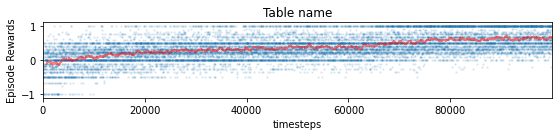

In [21]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Table name")

In [22]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

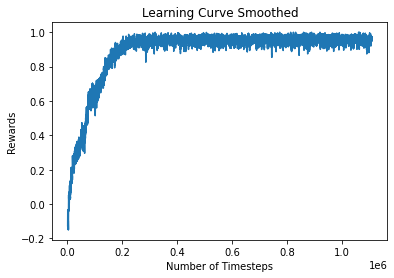

In [23]:
plot_results(log_dir)

In [27]:
env = MyEnv(max_num_functions=5, max_input=10)
env.reset()

[2, 8, 7, 8, 1, 8, 4, 9, 5, 1] 10
4
[2, 8, 7, 8, 1, 8, 4, 9]


{'points': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8),
 'features': array([2., 8., 7., 8., 1., 8., 4., 9., 0., 0.]),
 'action_history': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32)}

In [28]:
env.step({"function": 3, "input": 9})

[[3. 9. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


({'points': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int8),
  'features': array([2., 8., 7., 8., 1., 8., 4., 9., 0., 0.]),
  'action_history': array([[3., 9., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]], dtype=float32)},
 1,
 False,
 {})

In [ ]:
dc = DummyContractV2(num_fns, features)

In [10]:
dir(gym.spaces)

['Box',
 'Dict',
 'Discrete',
 'MultiBinary',
 'MultiDiscrete',
 'Space',
 'Tuple',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'box',
 'dict',
 'discrete',
 'flatdim',
 'flatten',
 'flatten_space',
 'multi_binary',
 'multi_discrete',
 'space',
 'tuple',
 'unflatten',
 'utils']

In [16]:
(2, 3) + (4, 5)

(2, 3, 4, 5)

In [33]:
b = spaces.Box(
    low=0.0, 
    high=1.0, 
    shape=(10, 5)
)
b.shape

(10, 5)

In [8]:
spaces.Dict({
    "points": spaces.MultiBinary(5), 
    "features": spaces.MultiDiscrete([10 for i in range(2 * 5)]),
    "action_history": spaces.Box(
        low=0.0, 
        high=10, 
        shape=(15, 5)
    )
}).sample()

OrderedDict([('action_history',
              array([[1.8066711 , 2.9890919 , 6.019261  , 4.67686   , 3.2270215 ],
                     [3.9573112 , 3.1858263 , 2.4332523 , 0.42170376, 7.0352054 ],
                     [2.2451136 , 1.404828  , 2.064434  , 7.6609116 , 1.3292111 ],
                     [0.06347949, 2.0168817 , 1.0336297 , 6.1379805 , 5.278453  ],
                     [9.80183   , 7.031457  , 1.289134  , 1.4286542 , 9.106412  ],
                     [9.737788  , 8.657428  , 6.9548597 , 0.799518  , 6.0859194 ],
                     [3.4112654 , 9.002056  , 6.0207267 , 3.6499624 , 7.531077  ],
                     [5.853317  , 0.7257287 , 7.375656  , 0.74590886, 9.674888  ],
                     [9.841174  , 7.3044086 , 5.6559286 , 5.5741415 , 8.845847  ],
                     [4.927478  , 6.6615987 , 8.577588  , 3.1652172 , 7.383477  ],
                     [4.61448   , 9.162831  , 4.26521   , 0.9749578 , 0.17799926],
                     [9.681989  , 9.029232  , 5.3188777

In [23]:
z = np.zeros(10)
o = np.ones(3)
z[0:3] = [1, 1, 1]
z

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
[[1], [2]]

[[1], [2]]

In [34]:
np.array([[1,2],[3,4]]).flatten()

array([1, 2, 3, 4])

In [124]:
from stellar_sdk import Keypair

Keypair.from_secret("SDTARUMXE5JTFB7MI3CIFOLXGBAJIGRZ4MSTLOTVJ2XIH33EBKCANQDL").raw_public_key().hex()

'a2e7dbc345d1a879e64cfaddfab198d3655d21b41766e94debd2b1a2b484791a'

In [45]:
t = torch.randn(1, 7, 3)
t[0, 1] = t[0, 0]
m = nn.Linear(3, 5)

In [46]:
m.weight

Parameter containing:
tensor([[ 0.2254,  0.1553,  0.5132],
        [-0.2180, -0.4014,  0.0298],
        [-0.3472,  0.4954, -0.4684],
        [-0.0492,  0.1083,  0.4056],
        [-0.4402, -0.3269, -0.4383]], requires_grad=True)

In [47]:
t

tensor([[[ 0.1954,  0.5282,  0.6225],
         [ 0.1954,  0.5282,  0.6225],
         [ 1.0196,  0.8855,  0.9625],
         [ 0.4920, -0.3205, -0.4694],
         [ 2.7847, -0.7034,  0.3286],
         [-0.6364,  1.5823, -0.6974],
         [ 0.7163, -2.5230, -1.0391]]])

In [43]:
m(t)

tensor([[[-1.2686, -0.0256,  0.8412,  0.5502,  0.0189],
         [-1.2686, -0.0256,  0.8412,  0.5502,  0.0189],
         [-1.0182,  0.0411,  0.0860,  0.5227,  0.4728],
         [ 0.5613,  0.5726, -0.6034, -0.3849,  0.4606],
         [-1.2339,  1.2220,  1.1933, -0.6740, -0.8359],
         [ 0.7820,  1.0854,  0.0727, -1.0384, -0.2889],
         [-0.7914,  0.1989,  0.4601,  0.2434,  0.1039],
         [-1.1928,  0.4442,  0.3060,  0.1719,  0.1502],
         [-0.5270,  0.2988, -0.3139,  0.1834,  0.5527],
         [-1.0877,  1.9598,  0.3778, -1.2810, -0.6510]]],
       grad_fn=<ViewBackward0>)

In [169]:
q = torch.randn(1, 7, 4)
k = torch.randn(1, 10, 5)
v = torch.randn(1, 10, 6)

In [170]:
mha = torch.nn.MultiheadAttention(
    embed_dim=4, 
    num_heads=2, 
    dropout=0.0, 
    bias=True, 
    add_bias_kv=False, 
    add_zero_attn=False, 
    kdim=5, 
    vdim=6, 
    batch_first=True, 
    device=None, 
    dtype=None
)

In [171]:
key_padding_mask = torch.tensor([[False, True, True, True, True, True, True, True, True, True]])
attn_output, attn_output_weights = mha(q, k, v, key_padding_mask=key_padding_mask)

In [172]:
attn_output, attn_output.size()

(tensor([[[-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223],
          [-1.1546,  0.1890, -1.1885, -1.3223]]], grad_fn=<TransposeBackward0>),
 torch.Size([1, 7, 4]))

In [162]:
q

tensor([[[ 0.0486, -0.6342, -1.4413, -1.5537],
         [-1.5929,  0.2420, -0.6904, -0.3219],
         [-0.2475,  1.7527,  1.1416, -0.6094],
         [-0.7674,  0.9008, -0.1188,  0.4237],
         [-1.1797,  0.3144,  1.3335,  0.2820],
         [-0.9853,  0.2039, -2.4896,  0.0520],
         [ 0.9821, -0.1935, -0.2306,  0.4600]]])

In [137]:
attn_output_weights.size()

torch.Size([1, 10, 7])

In [125]:
mha.q_proj_weight

Parameter containing:
tensor([[-0.5215,  0.3591, -0.1606, -0.3773],
        [ 0.0117,  0.0540,  0.5056, -0.4940],
        [ 0.8076, -0.5054,  0.3916, -0.1781],
        [ 0.4067, -0.3117, -0.7222,  0.6166]], requires_grad=True)

In [126]:
mha.k_proj_weight

Parameter containing:
tensor([[-7.4075e-01,  2.7383e-02,  3.3585e-01,  6.1743e-01,  5.2101e-01],
        [ 1.3673e-04, -8.0710e-01,  6.5254e-01,  2.0762e-01,  4.6144e-01],
        [-8.1145e-01,  7.8739e-01,  7.2257e-01,  6.5952e-02,  3.3717e-01],
        [ 7.9695e-01,  1.3206e-01, -6.0681e-01,  8.8172e-02,  7.2054e-01]],
       requires_grad=True)

In [129]:
mha.v_proj_weight

Parameter containing:
tensor([[ 0.7285, -0.6278, -0.1503, -0.1630, -0.1751, -0.7286],
        [ 0.3590, -0.1418, -0.2774, -0.2966,  0.0678,  0.1418],
        [-0.2482, -0.4547, -0.0364, -0.6998,  0.4701,  0.1494],
        [ 0.5341, -0.0446,  0.6826, -0.1015, -0.2243,  0.6125]],
       requires_grad=True)

In [132]:
mha.head_dim, mha.num_heads

(2, 2)

In [16]:
torch.randn(7, 4).unsqueeze(0).size()

torch.Size([1, 7, 4])

In [216]:
multi_head_attention = MultiHeadAttention(n_head=5, d_model=5, d_k=5, d_v=6)

In [217]:
q = torch.randn(1, 7, 5)
k = torch.randn(1, 10, 5)
v = torch.randn(1, 10, 5)

o, w = multi_head_attention(q, k, v)
o

tensor([[[ 0.5455, -0.7632, -0.3622,  1.6721, -1.0922],
         [ 1.3012, -1.4202, -0.5786, -0.2478,  0.9454],
         [ 0.0426, -0.3696,  1.1598,  0.8425, -1.6753],
         [ 1.6201,  0.0351, -0.1981, -1.5265,  0.0694],
         [-1.4236, -0.7666,  1.2259,  0.0251,  0.9393],
         [-1.7280,  1.3086, -0.2614,  0.3695,  0.3112],
         [ 1.0404,  0.4389,  0.8355, -1.5745, -0.7402]]],
       grad_fn=<NativeLayerNormBackward0>)

In [218]:
q.transpose(1, 2)

tensor([[[-0.4014,  1.8224, -0.3020,  1.5385, -0.8151, -0.5202,  1.3501],
         [-0.7472, -1.3870, -0.5662,  0.2226, -0.3619,  1.5350,  0.8623],
         [-0.8376, -0.4755,  0.6338, -0.2226,  0.2657,  0.4583,  1.0264],
         [ 0.0283,  0.0478,  0.4421, -1.3932, -0.1969,  0.9932, -1.6617],
         [-1.1351,  1.3394, -2.0995,  0.0468,  0.0636,  0.5746, -0.7659]]])

In [288]:
q = torch.ones(1, 7, 5)
q.size()

torch.Size([1, 7, 5])

In [305]:
qs = torch.sum(q, dim=1)
qs

tensor([[7., 7., 7., 7., 7.]])

In [306]:
qs.size()

torch.Size([1, 5])

In [206]:
b = 1
torch.randn(b, 20).reshape(b, -1, 5).shape

torch.Size([1, 4, 5])